In [23]:
import os
import cv2
import csv
import glob
import pandas as pd
import numpy as np
import random
import itertools
from collections import Counter
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
import os 
import pandas as pd 

# path = '/home/dreamer/Private/Competition/Kaggle/GlobalWheaetDetection/dataset/train.csv'
path = '/home/dreamer/workspace/RongWen/scripts/voc2007.csv'
train_csv = pd.read_csv(path)
train_csv.head()

,image_id,width,height,bbox,source
0,834,500,375,"['304.0', '85.0', '65.0', '40.0']",cow
1,834,500,375,"['249.0', '72.0', '64.0', '30.0']",cow
2,834,500,375,"['10.0', '96.0', '90.0', '58.0']",cow
3,834,500,375,"['69.0', '123.0', '108.0', '51.0']",cow
4,834,500,375,"['64.0', '95.0', '81.0', '26.0']",cow


In [25]:
train_csv.tail()

,image_id,width,height,bbox,source
30633,4846,500,338,"['3.0', '58.0', '496.0', '280.0']",sofa
30634,4846,500,338,"['137.0', '148.0', '363.0', '190.0']",person
30635,4846,500,338,"['201.0', '3.0', '299.0', '239.0']",person
30636,4535,480,445,"['80.0', '100.0', '321.0', '323.0']",horse
30637,4535,480,445,"['215.0', '40.0', '109.0', '231.0']",person


In [26]:
train_csv['source'].unique()

array(['cow', 'person', 'dog', 'tvmonitor', 'car', 'sofa', 'bottle',
       'chair', 'pottedplant', 'bicycle', 'train', 'sheep', 'aeroplane',
       'bird', 'horse', 'diningtable', 'bus', 'boat', 'cat', 'motorbike'],
      dtype=object)

Text(0.5, 1.0, 'Distribution of Source')

No handles with labels found to put in legend.


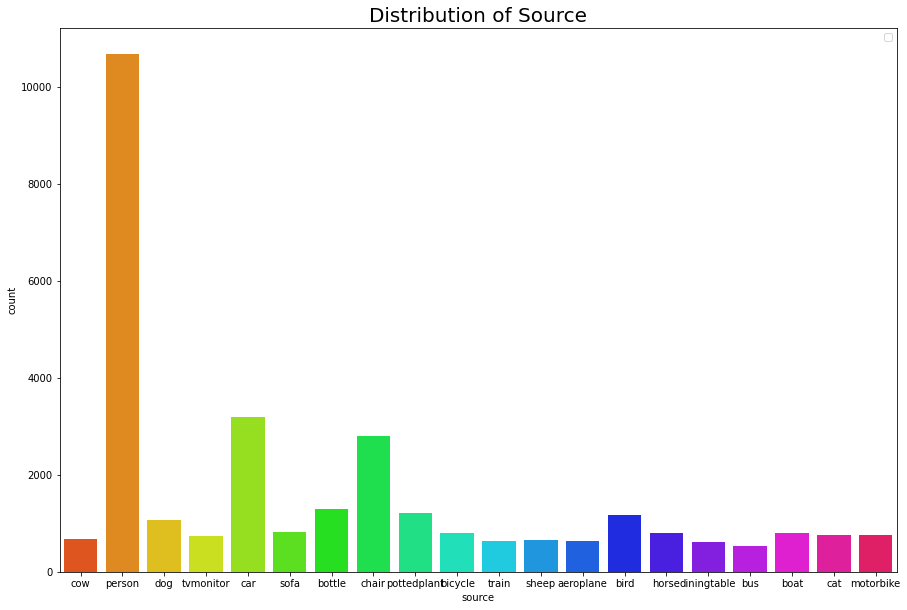

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['figure.figsize'] = (15, 10)
sns.countplot(train_csv['source'], palette = 'hsv')
plt.title('Distribution of Source', fontsize = 20)
plt.legend()
plt.show()

([<matplotlib.patches.Wedge at 0x7f4293577210>,
 [Text(0.5043377934975438, 0.9775701458463372, 'cow'),
  Text(-0.8914146002209405, 0.6444998142070646, 'person'),
  Text(-1.1499214302071443, 0.013442631824008868, 'dog'),
  Text(-1.055415030843979, -0.4567265184643905, 'tvmonitor'),
  Text(-1.0225254278781133, -0.8027712932975876, 'car'),
  Text(-0.7969919635487224, -1.0270364209894174, 'sofa'),
  Text(-0.5418687654609411, -1.181684493008957, 'bottle'),
  Text(-0.28087025773611984, -1.1666670040415328, 'chair'),
  Text(-0.08311316315885107, -1.1971182907756988, 'pottedplant'),
  Text(0.11450519136234766, -1.1945244079344182, 'bicycle'),
  Text(0.3071148424137866, -1.1600346863646602, 'train'),
  Text(0.4868396229037978, -1.0968077231542857, 'sheep'),
  Text(0.6509882123253468, -1.008074574331408, 'aeroplane'),
  Text(0.7965474203107237, -0.8975033187661934, 'bird'),
  Text(0.9177840258582377, -0.773092802889437, 'horse'),
  Text(1.0156151833095008, -0.6391602298572785, 'diningtable'),
  

Text(0.5, 1.0, 'Source')

(-1.25, 1.25, -1.25, 1.25)

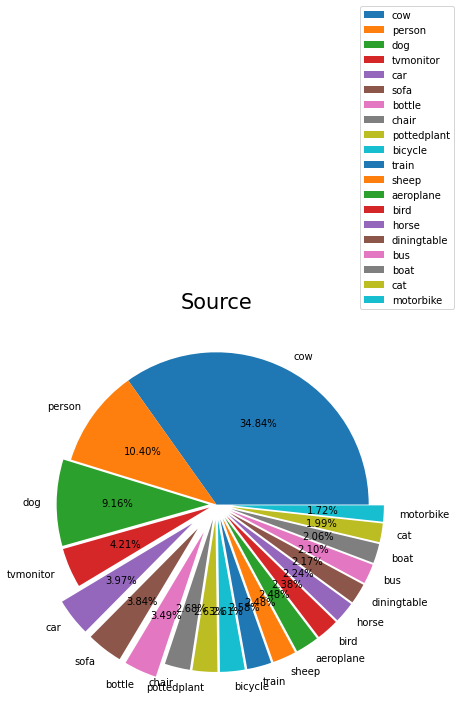

In [28]:
# the length of labels must be eqaul to the length of explode
labels = list(train_csv['source'].unique())
plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(train_csv['source'].value_counts(),labels=labels,explode = [0.0,0.0,0.05,0.05,0.2,0.2,0.2] +  [0.1]*13, autopct = '%.2f%%')
plt.title('Source', fontsize = 21)
plt.axis('off')
plt.legend(loc='lower center', bbox_to_anchor=(1, 1))
plt.show()

In [29]:
# generating bbox area 
from ast import literal_eval

def get_bbox_area(bbox):
    bbox = literal_eval(bbox)
    return float(bbox[2]) * float(bbox[3])
train_csv['bbox_area'] = train_csv['bbox'].apply(get_bbox_area)
# train_csv['bbox_area'].value_counts().hist(bins=33)
train_csv.head()

,image_id,width,height,bbox,source,bbox_area
0,834,500,375,"['304.0', '85.0', '65.0', '40.0']",cow,2600.0
1,834,500,375,"['249.0', '72.0', '64.0', '30.0']",cow,1920.0
2,834,500,375,"['10.0', '96.0', '90.0', '58.0']",cow,5220.0
3,834,500,375,"['69.0', '123.0', '108.0', '51.0']",cow,5508.0
4,834,500,375,"['64.0', '95.0', '81.0', '26.0']",cow,2106.0


In [30]:
# get image area 
def get_image_area(width, height):
    return float(width) * float(height)
  
 
train_csv['image_area'] = train_csv.apply(lambda row: get_image_area(row['width'], row['height']), axis=1)
train_csv.head()

,image_id,width,height,bbox,source,bbox_area,image_area
0,834,500,375,"['304.0', '85.0', '65.0', '40.0']",cow,2600.0,187500.0
1,834,500,375,"['249.0', '72.0', '64.0', '30.0']",cow,1920.0,187500.0
2,834,500,375,"['10.0', '96.0', '90.0', '58.0']",cow,5220.0,187500.0
3,834,500,375,"['69.0', '123.0', '108.0', '51.0']",cow,5508.0,187500.0
4,834,500,375,"['64.0', '95.0', '81.0', '26.0']",cow,2106.0,187500.0


In [31]:
def get_bbox_ratio(bbox_area, image_area):
    return float(bbox_area) / float(image_area)
  
 
train_csv['bbox_ratio'] = train_csv.apply(lambda row: get_bbox_ratio(row['bbox_area'], row['image_area']), axis=1)
train_csv.head()

,image_id,width,height,bbox,source,bbox_area,image_area,bbox_ratio
0,834,500,375,"['304.0', '85.0', '65.0', '40.0']",cow,2600.0,187500.0,0.013867
1,834,500,375,"['249.0', '72.0', '64.0', '30.0']",cow,1920.0,187500.0,0.010240
2,834,500,375,"['10.0', '96.0', '90.0', '58.0']",cow,5220.0,187500.0,0.027840
3,834,500,375,"['69.0', '123.0', '108.0', '51.0']",cow,5508.0,187500.0,0.029376
4,834,500,375,"['64.0', '95.0', '81.0', '26.0']",cow,2106.0,187500.0,0.011232


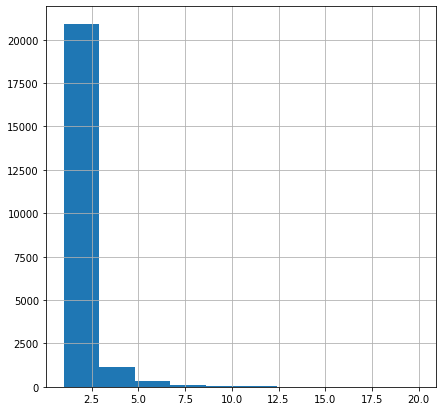

In [32]:
train_csv['bbox_ratio'].value_counts().hist()

In [35]:
# def get_bbox_area(bbox):
#     bbox = literal_eval(bbox)
#     return float(bbox[2]) * float(bbox[3])
# train_csv['bbox_area'] = train_csv['bbox'].apply(get_bbox_area)

# get image area 
def get_bbox_imsize_area(bbox, imsize, index):
    bbox = literal_eval(bbox)
    return float(bbox[index]) /float(imsize)
  
train_csv['box_width_ratio'] = train_csv.apply(lambda row: get_bbox_imsize_area(row['bbox'], row['width'], 2), axis=1)

train_csv['box_height_ratio'] = train_csv.apply(lambda row: get_bbox_imsize_area(row['bbox'], row['height'], 3), axis=1)



# train_csv['bbox_area'].value_counts().hist(bins=33)
train_csv.head()

,image_id,width,height,bbox,source,bbox_area,image_area,bbox_ratio,box_width_ratio,box_height_ratio
0,834,500,375,"['304.0', '85.0', '65.0', '40.0']",cow,2600.0,187500.0,0.013867,0.130,0.106667
1,834,500,375,"['249.0', '72.0', '64.0', '30.0']",cow,1920.0,187500.0,0.010240,0.128,0.080000
2,834,500,375,"['10.0', '96.0', '90.0', '58.0']",cow,5220.0,187500.0,0.027840,0.180,0.154667
3,834,500,375,"['69.0', '123.0', '108.0', '51.0']",cow,5508.0,187500.0,0.029376,0.216,0.136000
4,834,500,375,"['64.0', '95.0', '81.0', '26.0']",cow,2106.0,187500.0,0.011232,0.162,0.069333


## scatter img to show the bbox width, bbox height ratio distribution to help setting anchor size

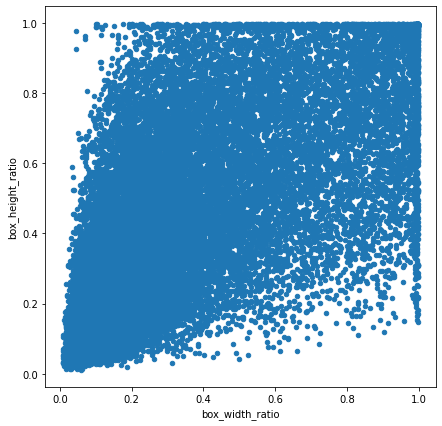

In [36]:
train_csv.plot.scatter(x='box_width_ratio', y='box_height_ratio')
plt.show()

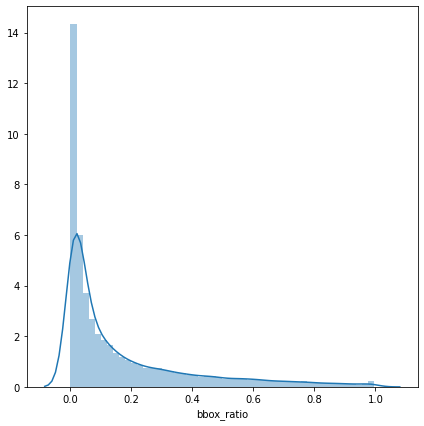

In [21]:
# display the ratio distribution in dataset
sns.distplot(train_csv['bbox_ratio'])

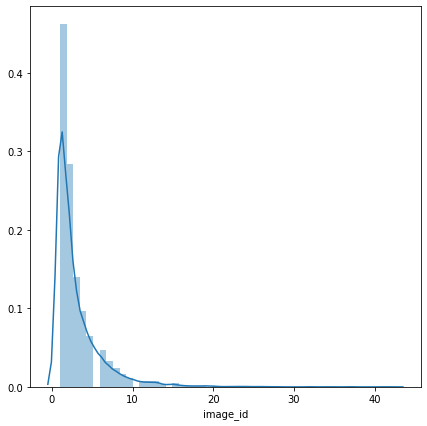

In [25]:
# display how many bbox in each image 

sns.distplot(train_csv['image_id'].value_counts())

In [28]:
train_csv.info

<bound method DataFrame.info of        image_id  width  height                                  bbox  source  \
0           834    500     375     ['304.0', '85.0', '65.0', '40.0']     cow   
1           834    500     375     ['249.0', '72.0', '64.0', '30.0']     cow   
2           834    500     375      ['10.0', '96.0', '90.0', '58.0']     cow   
3           834    500     375    ['69.0', '123.0', '108.0', '51.0']     cow   
4           834    500     375      ['64.0', '95.0', '81.0', '26.0']     cow   
...         ...    ...     ...                                   ...     ...   
30633      4846    500     338     ['3.0', '58.0', '496.0', '280.0']    sofa   
30634      4846    500     338  ['137.0', '148.0', '363.0', '190.0']  person   
30635      4846    500     338    ['201.0', '3.0', '299.0', '239.0']  person   
30636      4535    480     445   ['80.0', '100.0', '321.0', '323.0']   horse   
30637      4535    480     445   ['215.0', '40.0', '109.0', '231.0']  person   

       

In [30]:
train_csv["image_id"] = train_csv["image_id"].apply(lambda x: str(x) + ".jpg")
train_csv.head()

,image_id,width,height,bbox,source,bbox_area,image_area,bbox_ratio
0,834.jpg,500,375,"['304.0', '85.0', '65.0', '40.0']",cow,2600.0,187500.0,0.013867
1,834.jpg,500,375,"['249.0', '72.0', '64.0', '30.0']",cow,1920.0,187500.0,0.010240
2,834.jpg,500,375,"['10.0', '96.0', '90.0', '58.0']",cow,5220.0,187500.0,0.027840
3,834.jpg,500,375,"['69.0', '123.0', '108.0', '51.0']",cow,5508.0,187500.0,0.029376
4,834.jpg,500,375,"['64.0', '95.0', '81.0', '26.0']",cow,2106.0,187500.0,0.011232


In [ ]:
def skip_csv_header(file):
    has_header = csv.Sniffer().has_header(file.read(1024))
    file.seek(0)
    if has_header:
        next(file)


def total_image_list(image_folder_path):
    total_img_list = [os.path.basename(img_path_name) for img_path_name in glob.glob(os.path.join(image_folder_path, "*.jpg"))]
    return total_img_list

def draw_rect(img, bboxes, color=None):
    img = img.copy()
    bboxes = bboxes[:, :4]
    bboxes = bboxes.reshape(-1, 4)
    for bbox in bboxes:
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=ceil(len(img_matrix_list) / ncols), ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

### 随机显示部分图像

In [ ]:
image_folder_path = '/home/dreamer/workspace/RongWen/data/Processing/VOCdevkit/VOC2012/JPEGImages'

def plot_random_images(image_folder_path, image_annotation_file, num = 12):
    img_dict = {}
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 images to plot
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    img_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]  
        img_matrix_list.append(img)

    
    return plot_multiple_img(img_matrix_list, title_list = img_files_list, ncols = 4, main_title="Wheat Images")

plot_random_images(image_folder_path, path, num = 12)

In [8]:
import pandas as pd
demo = '/home/dreamer/workspace/RongWen/scripts/rongwen20201117.csv'
demo_csv = pd.read_csv(demo)
demo_csv.image_id.value_counts()

1605680612_8946      8
1605680612_7910      7
1605680612_18018     7
1605680594_180       6
1605680612_180183    5
1605680595_930       4
1605680612_106963    4
1605680612_106962    4
1605680595_3451      4
1605680612_89463     4
1605680595_9301      4
1605680612_180182    4
1605680595_345       4
1605680612_79103     4
1605680608_120       3
1605680608_1200      3
1605680594_1801      3
1605680608_390       3
1605680608_3900      3
1605680594_1800      3
1605680612_79102     3
1605680608_3750      3
1605680608_375       3
1605680741_303       2
1605680741_750       2
1605680741_480       2
1605680741_2403      2
1605680741_2703      2
1605680612_106960    1
1605680741_30        1
1605680612_89460     1
1605680612_79100     1
Name: image_id, dtype: int64

In [11]:
print(demo_csv[demo_csv['image_id']=='1605680612_8946'])

           image_id  width  height                         bbox        source
57  1605680612_8946   1908    1062   [224.0, 449.0, 52.0, 87.0]  traffic cone
58  1605680612_8946   1908    1062  [1461.0, 854.0, 25.0, 37.0]  traffic cone
59  1605680612_8946   1908    1062  [1635.0, 843.0, 21.0, 34.0]  traffic cone
60  1605680612_8946   1908    1062  [1659.0, 831.0, 16.0, 31.0]  traffic cone
61  1605680612_8946   1908    1062  [1574.0, 825.0, 60.0, 37.0]         fence
62  1605680612_8946   1908    1062   [490.0, 627.0, 18.0, 26.0]  traffic cone
63  1605680612_8946   1908    1062   [598.0, 625.0, 14.0, 18.0]  traffic cone
64  1605680612_8946   1908    1062   [552.0, 610.0, 41.0, 25.0]         fence


In [20]:
demo_csv[demo_csv['image_id']=='1605680612_8946']['bbox'][57][1:-1].split(',')

['224.0', ' 449.0', ' 52.0', ' 87.0']

In [21]:
for index in demo_csv[demo_csv['image_id']=='1605680612_8946']['bbox']:
    print(index[1:-1].split(','))

['224.0', ' 449.0', ' 52.0', ' 87.0']
['1461.0', ' 854.0', ' 25.0', ' 37.0']
['1635.0', ' 843.0', ' 21.0', ' 34.0']
['1659.0', ' 831.0', ' 16.0', ' 31.0']
['1574.0', ' 825.0', ' 60.0', ' 37.0']
['490.0', ' 627.0', ' 18.0', ' 26.0']
['598.0', ' 625.0', ' 14.0', ' 18.0']
['552.0', ' 610.0', ' 41.0', ' 25.0']
